In [1]:
import os
import pandas as pd
from omegaconf import OmegaConf
import matplotlib.pyplot as plt


config = OmegaConf.load("lstm_config.yaml")

In [2]:
def results_dataframe():
    """
    Lê e combina dados de múltiplos arquivos CSV em diferentes diretórios.
    
    Returns:
        DataFrame: Combina todos os CSVs encontrados com uma coluna adicional 'Model_covariates'
                  indicando o diretório de origem.
    """
    df_aux = pd.DataFrame()
    for directory in os.listdir(config.paths.eval_folder):
        for csv in os.listdir(config.paths.eval_folder+directory):
            df_temp = pd.read_csv(config.paths.eval_folder+directory+"/"+csv)
            df_temp['Model_covariates'] = directory
            df_aux = pd.concat([df_aux,df_temp])
    return df_aux

def house_result_variation_calculate(house,df_):
    """
    Calcula a variação das métricas de avaliação para uma casa específica em relação
    ao modelo base (#).
    
    Args:
        house: Identificador da casa a ser analisada
        
    Returns:
        DataFrame: Dados originais com colunas adicionais mostrando as variações das métricas
    """
    df_filtred = df_[df_.House_Hold == house]
    metrics_values = df_filtred[["MAE","SMAPE","RMSE"]].loc[df_filtred.Model_covariates == "#"]
    variation = df_filtred[["MAE","SMAPE","RMSE"]].sub(metrics_values)
    variation.rename(columns={a:b for a,b in zip(variation.columns,[x+"_variation" for x in variation.columns])},inplace=True)
    variation = pd.concat([df_filtred,variation],axis=1)
    return variation


def check_better_results(df_house_variation):
    """
    Analisa as variações e identifica onde houve melhorias nas métricas.
    Uma variação negativa indica melhoria em relação ao modelo base.
    Depois soma as colunas resumindo as variaveis booleanas

    Args:
        df_house_variation: DataFrame com as variações calculadas
        
    Returns:
        DataFrame: Sumário das melhorias por casa, onde para cada coluna apresenta a soma de quantas vezes uma covariavel adicionada ao modelo 
                   apresentou melhor desempenho que o modelo sem covariaveis
    """
    df_temp = df_house_variation
    for variation in df_temp.columns[-3:]:
        name_col = variation+"_bool"
        df_temp[name_col] = df_temp[variation].apply(lambda x : 1 if x < 0 else 0)
    df_better_results = df_temp[["House_Hold","MAE_variation_bool","SMAPE_variation_bool","RMSE_variation_bool"]].groupby("House_Hold").sum()
    df_better_results = df_better_results.reset_index()
    return df_better_results


def condense_results():
    """
    Função principal que coordena todo o processo de análise.
    Processa os dados de todas as casas e gera um relatório final
    mostrando onde houve melhorias nas métricas. 
    Salva em um csv.
    
    Returns:
        DataFrame: Resumo final das melhorias por casa
    """
    df_temp = results_dataframe()
    df_aux = pd.DataFrame()
    for house in df_temp.House_Hold.unique():
        a = house_result_variation_calculate(house,df_temp)
        b = check_better_results(a)
        df_aux = pd.concat([df_aux,b])
    df_aux.sort_values("MAE_variation_bool",ascending=False,inplace=True)
    df_aux.to_csv("resultados_condensados.csv")    
    return df_aux.sort_values("MAE_variation_bool",ascending=False)

In [3]:
condense_results()

,House_Hold,MAE_variation_bool,SMAPE_variation_bool,RMSE_variation_bool
0,STRETCHEDSOCIETY_BLOCK_98_MAC004892,6,5,4
0,STRETCHEDSOCIETY_BLOCK_97_MAC001314,6,6,3
0,ESTABLISHEDAFFLUENCE_BLOCK_13_MAC005411,6,5,3
0,ESTABLISHEDAFFLUENCE_BLOCK_34_MAC002265,6,6,2
0,STRETCHEDSOCIETY_BLOCK_94_MAC000838,6,6,4
...,...,...,...,...
0,ESTABLISHEDAFFLUENCE_BLOCK_26_MAC002966,0,0,0
0,ESTABLISHEDAFFLUENCE_BLOCK_17_MAC002007,0,3,0
0,STRETCHEDSOCIETY_BLOCK_99_MAC004771,0,5,0
0,STRETCHEDSOCIETY_BLOCK_94_MAC000870,0,0,0


In [4]:
df = results_dataframe()
df_auxiliar = pd.DataFrame()
for house in df.House_Hold.unique():
    a = house_result_variation_calculate(house,df)
    df_auxiliar = pd.concat([df_auxiliar,a])
df_auxiliar[~df_auxiliar.House_Hold.isin(df_auxiliar[df_auxiliar.MAE_variation.isnull()].House_Hold.unique())]

,House_Hold,MAE,MAPE,SMAPE,RMSE,Time_execution,Model_covariates,MAE_variation,SMAPE_variation,RMSE_variation
0,STRETCHEDSOCIETY_BLOCK_91_MAC001165,0.070,989939.440,1.058,0.150,265.43s,dayofweek_num,0.000,-0.044,-0.004
0,STRETCHEDSOCIETY_BLOCK_91_MAC001165,0.054,508220.470,0.975,0.130,265.51s,hour,-0.016,-0.127,-0.024
0,STRETCHEDSOCIETY_BLOCK_91_MAC001165,0.069,822453.440,1.084,0.152,301.24s,holiday,-0.001,-0.018,-0.002
0,STRETCHEDSOCIETY_BLOCK_91_MAC001165,0.070,990743.300,1.054,0.151,287.98s,precipType,0.000,-0.048,-0.003
0,STRETCHEDSOCIETY_BLOCK_91_MAC001165,0.075,1539828.800,1.043,0.147,260.72s,month,0.005,-0.059,-0.007
...,...,...,...,...,...,...,...,...,...,...
0,ESTABLISHEDAFFLUENCE_BLOCK_17_MAC002007,0.217,0.531,0.433,0.434,376.94s,holiday,0.035,-0.001,0.058
0,ESTABLISHEDAFFLUENCE_BLOCK_17_MAC002007,0.209,0.561,0.432,0.419,433.80s,precipType,0.027,-0.002,0.043
0,ESTABLISHEDAFFLUENCE_BLOCK_17_MAC002007,0.217,0.585,0.462,0.432,604.98s,month,0.035,0.028,0.056
0,ESTABLISHEDAFFLUENCE_BLOCK_17_MAC002007,0.182,0.676,0.434,0.376,526.26s,#,0.000,0.000,0.000


In [5]:
def calculate_percentage_variation(house, df_):
   """
   Calcula a porcentagem de variação das métricas em relação ao modelo base.
   Args:
       house: Identificador da casa
       df_: DataFrame com os dados
   Returns:
       DataFrame: Dados com colunas de variação percentual 
   """
   # Aproveita função existente para obter variações
   df_variations = house_result_variation_calculate(house, df_)
   
   # Valores do modelo base
   base_values = df_variations[["MAE","SMAPE","RMSE"]].loc[df_variations.Model_covariates == "#"]
   pct_df = df_variations[["MAE","SMAPE","RMSE"]].div(base_values).sub(1).mul(100).round(2)
   pct_df.rename(columns={a:b for a,b in zip(pct_df.columns,[x+"_pct" for x in pct_df.columns])},inplace=True)
   pct_df = pd.concat([df_variations,pct_df],axis=1)
   return pct_df


In [6]:
df = results_dataframe()
df_auxiliar = pd.DataFrame()
for house in df.House_Hold.unique():
    a = calculate_percentage_variation(house,df)
    df_auxiliar = pd.concat([df_auxiliar,a])
df_auxiliar= df_auxiliar[~df_auxiliar.House_Hold.isin(df_auxiliar[df_auxiliar.MAE_variation.isnull()].House_Hold.unique())]
df_auxiliar[~df_auxiliar.House_Hold.isin(df_auxiliar[df_auxiliar.MAE_variation.isnull()].House_Hold.unique())].to_csv("pct_variacao.csv")
df_auxiliar = df_auxiliar[df_auxiliar.Model_covariates != "#"]

In [7]:
df_auxiliar[["House_Hold","MAE_pct","SMAPE_pct","RMSE_pct"]].groupby("House_Hold").mean().sort_values("MAE_pct",ascending=True).to_csv("media_variacao.csv")

In [8]:
import dtale
import dtale.global_state as global_state
global_state.set_app_settings(dict(enable_custom_filters=True))

df = pd.read_csv("pct_variacao.csv")
d = dtale.show(df)
d.kill()

# using Python's `webbrowser` package it will try and open your server's default browser to this process
d.open_browser()

Turning on custom filtering. Custom filters are vulnerable to code injection attacks, please only use in trusted environments.
2024-12-12 07:05:21,703 - WARNING  - Custom filtering enabled. Custom filters are vulnerable to code injection attacks, please only use in trusted environments.


In [9]:
df = pd.read_csv("pct_variacao.csv")

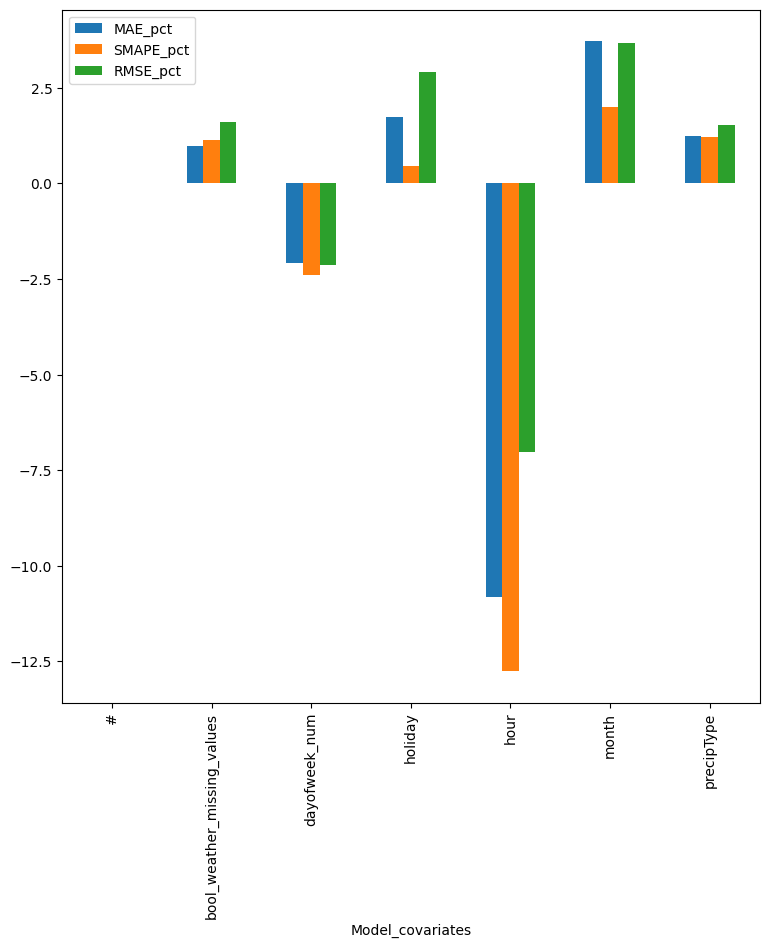

In [10]:
df[["Model_covariates","MAE_pct","SMAPE_pct","RMSE_pct"]].groupby("Model_covariates").mean().plot(kind="bar",figsize = (9,9))
plt.show()

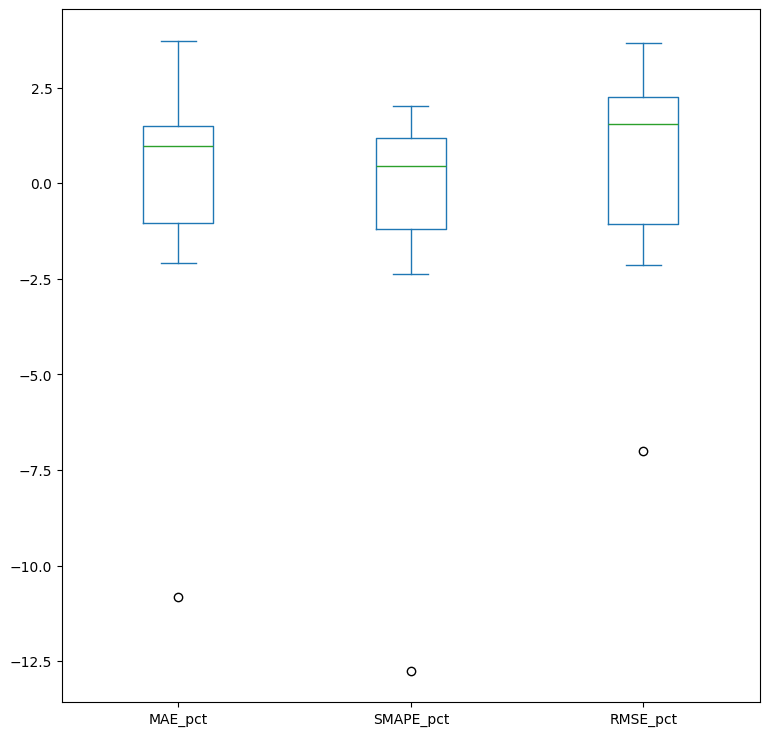

In [11]:
df[["Model_covariates","MAE_pct","SMAPE_pct","RMSE_pct"]].groupby("Model_covariates").mean().plot(kind="box",figsize = (9,9))
plt.show()

/home/carlos/anaconda3/envs/tensorflow-park/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning:

23.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/home/carlos/anaconda3/envs/tensorflow-park/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning:

20.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/home/carlos/anaconda3/envs/tensorflow-park/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning:

26.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/home/carlos/anaconda3/envs/tensorflow-park/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning:

16.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/home/carlos/anaconda3/envs/tensorflow-park/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarnin

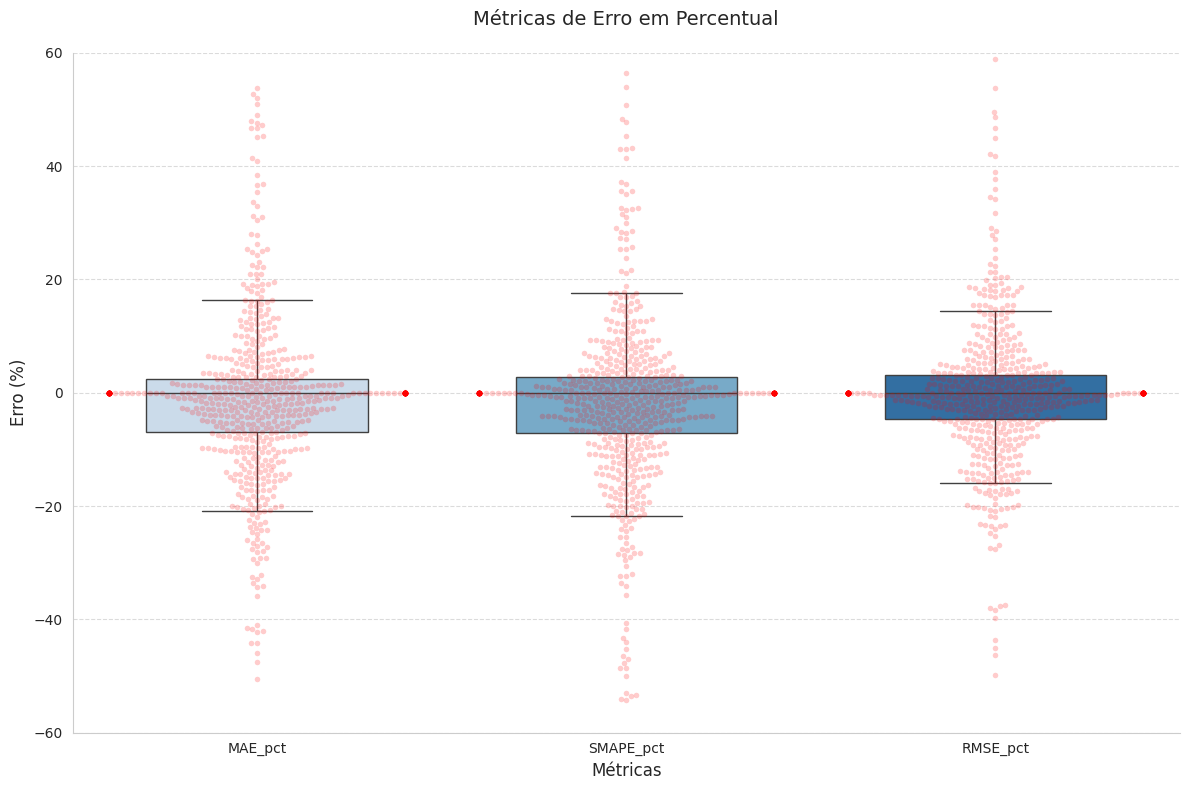

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurando o estilo
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Criando o box plot com pontos
# Primeiro o boxplot
ax = sns.boxplot(data=df[["MAE_pct", "SMAPE_pct", "RMSE_pct"]], 
                palette="Blues",
                width=0.6,
                showfliers=False)

# Adicionando os pontos individuais
sns.swarmplot(data=df[["MAE_pct", "SMAPE_pct", "RMSE_pct"]], 
              color='red',
              alpha=0.2,
              size=4)  # Dispersão horizontal dos pontos

# Personalizando o gráfico
plt.title("Métricas de Erro em Percentual", 
          fontsize=14, 
          pad=20)
plt.ylabel("Erro (%)", 
          fontsize=12)
plt.xlabel("Métricas", 
          fontsize=12)

# Ajustando os limites do eixo y
plt.ylim(-60, 60)

# Adicionando uma grade mais suave
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.grid(False)

# Personalizando as bordas
sns.despine(left=False, bottom=False)

# Ajustando o layout
plt.tight_layout()

plt.show()

In [14]:
def analyze_distribution_by_covariate(df, metrics_cols, covariate_values):
    """
    Analisa a distribuição dos dados por quartis e outliers para cada métrica,
    separando por tipo de covariável
    
    Parameters:
    df (pandas.DataFrame): DataFrame com os dados
    metrics_cols (list): Lista de colunas de métricas para análise
    covariate_values (list): Lista de valores da coluna Model_covariates para filtrar
    
    Returns:
    dict: Dicionário com as análises por covariável e métrica
    """
    results = {}
    
    for covariate in covariate_values:
        # Filtra o DataFrame para a covariável atual
        df_filtered = df[df['Model_covariates'] == covariate]
        
        results[covariate] = {}
        
        for col in metrics_cols:
            # Calcula os quartis
            Q1 = df_filtered[col].quantile(0.25)
            Q2 = df_filtered[col].quantile(0.50)
            Q3 = df_filtered[col].quantile(0.75)
            
            # Calcula o IQR e os limites para outliers
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Conta elementos em cada quartil
            first_quartile = df_filtered[(df_filtered[col] >= lower_bound) & 
                                       (df_filtered[col] < Q1)][col].count()
            second_quartile = df_filtered[(df_filtered[col] >= Q1) & 
                                        (df_filtered[col] < Q2)][col].count()
            third_quartile = df_filtered[(df_filtered[col] >= Q2) & 
                                       (df_filtered[col] < Q3)][col].count()
            fourth_quartile = df_filtered[(df_filtered[col] >= Q3) & 
                                        (df_filtered[col] <= upper_bound)][col].count()
            
            # Conta outliers
            outliers_low = df_filtered[df_filtered[col] < lower_bound][col].count()
            outliers_high = df_filtered[df_filtered[col] > upper_bound][col].count()
            
            results[covariate][col] = {
                'Primeiro Quartil': first_quartile,
                'Segundo Quartil': second_quartile,
                'Terceiro Quartil': third_quartile,
                'Quarto Quartil': fourth_quartile,
                'Outliers Negativos': outliers_low,
                'Outliers Positivos': outliers_high,
                'Limites': {
                    'Q1': Q1,
                    'Q2 (Mediana)': Q2,
                    'Q3': Q3,
                    'Limite Inferior': lower_bound,
                    'Limite Superior': upper_bound
                }
            }
    
    return results

# Lista de covariáveis
covariaveis = ['month', 'precipType', 'holiday', 'hour', 
               'dayofweek_num', 'bool_weather_missing_values']

# Lista de métricas
metricas = ["MAE_pct", "SMAPE_pct", "RMSE_pct"]

# Usando a função
resultados = analyze_distribution_by_covariate(df, metricas, covariaveis)

# Imprimindo os resultados de forma organizada
for covariavel, metricas_dict in resultados.items():
    print(f"\nAnálise para covariável: {covariavel}")
    print("=" * 70)
    
    for metrica, dados in metricas_dict.items():
        print(f"\nMétrica: {metrica}")
        print("-" * 50)
        print(f"Distribuição por quartis:")
        print(f"1º Quartil: {dados['Primeiro Quartil']} elementos")
        print(f"2º Quartil: {dados['Segundo Quartil']} elementos")
        print(f"3º Quartil: {dados['Terceiro Quartil']} elementos")
        print(f"4º Quartil: {dados['Quarto Quartil']} elementos")
        print(f"\nOutliers:")
        print(f"Negativos: {dados['Outliers Negativos']} elementos")
        print(f"Positivos: {dados['Outliers Positivos']} elementos")
        print(f"\nLimites:")
        for nome, valor in dados['Limites'].items():
            print(f"{nome}: {valor:.2f}")


Análise para covariável: month

Métrica: MAE_pct
--------------------------------------------------
Distribuição por quartis:
1º Quartil: 24 elementos
2º Quartil: 15 elementos
3º Quartil: 32 elementos
4º Quartil: 15 elementos

Outliers:
Negativos: 0 elementos
Positivos: 9 elementos

Limites:
Q1: -4.92
Q2 (Mediana): 0.00
Q3: 6.42
Limite Inferior: -21.94
Limite Superior: 23.44

Métrica: SMAPE_pct
--------------------------------------------------
Distribuição por quartis:
1º Quartil: 23 elementos
2º Quartil: 23 elementos
3º Quartil: 24 elementos
4º Quartil: 16 elementos

Outliers:
Negativos: 1 elementos
Positivos: 8 elementos

Limites:
Q1: -5.04
Q2 (Mediana): 0.74
Q3: 6.09
Limite Inferior: -21.73
Limite Superior: 22.79

Métrica: RMSE_pct
--------------------------------------------------
Distribuição por quartis:
1º Quartil: 20 elementos
2º Quartil: 17 elementos
3º Quartil: 30 elementos
4º Quartil: 15 elementos

Outliers:
Negativos: 4 elementos
Positivos: 9 elementos

Limites:
Q1: -2.83

In [15]:
def results_to_dataframe(results):
    """
    Converte os resultados para um DataFrame mais organizado incluindo
    contagem de elementos antes e depois da mediana
    """
    data = []
    
    for covariavel, metricas in results.items():
        for metrica, dados in metricas.items():
            # Calcula elementos antes e depois da mediana
            antes_mediana = dados['Primeiro Quartil'] + dados['Segundo Quartil'] + dados['Outliers Negativos']
            depois_mediana = dados['Terceiro Quartil'] + dados['Quarto Quartil'] + dados['Outliers Positivos']
            
            row = {
                'Covariável': covariavel,
                'Métrica': metrica,
                'Primeiro Quartil': dados['Primeiro Quartil'],
                'Segundo Quartil': dados['Segundo Quartil'],
                'Terceiro Quartil': dados['Terceiro Quartil'],
                'Quarto Quartil': dados['Quarto Quartil'],
                'Elementos Antes Mediana': antes_mediana,
                'Elementos Depois Mediana': depois_mediana,
                'Outliers Negativos': dados['Outliers Negativos'],
                'Outliers Positivos': dados['Outliers Positivos']
            }
            # Adiciona os limites
            for nome, valor in dados['Limites'].items():
                row[nome] = valor
            data.append(row)
    
    df = pd.DataFrame(data)
    
    # Reordenando as colunas para melhor visualização
    column_order = [
        'Covariável', 'Métrica',
        'Elementos Antes Mediana', 'Elementos Depois Mediana',
        'Primeiro Quartil', 'Segundo Quartil', 
        'Terceiro Quartil', 'Quarto Quartil',
        'Outliers Negativos', 'Outliers Positivos',
        'Q1', 'Q2 (Mediana)', 'Q3',
        'Limite Inferior', 'Limite Superior'
    ]
    
    return df[column_order]

# Usando a função
df_resultados = results_to_dataframe(resultados)

pd.set_option('display.float_format', lambda x: '%.2f' % x)


df_resultados


,Covariável,Métrica,Elementos Antes Mediana,Elementos Depois Mediana,Primeiro Quartil,Segundo Quartil,Terceiro Quartil,Quarto Quartil,Outliers Negativos,Outliers Positivos,Q1,Q2 (Mediana),Q3,Limite Inferior,Limite Superior
0,month,MAE_pct,39,56,24,15,32,15,0,9,-4.92,0.00,6.42,-21.94,23.44
1,month,SMAPE_pct,47,48,23,23,24,16,1,8,-5.04,0.74,6.09,-21.73,22.79
2,month,RMSE_pct,41,54,20,17,30,15,4,9,-2.83,0.00,5.42,-15.21,17.81
3,precipType,MAE_pct,46,47,18,23,23,17,5,7,-5.49,-0.65,5.07,-21.33,20.91
4,precipType,SMAPE_pct,46,47,19,23,23,15,4,9,-6.78,-0.74,4.82,-24.18,22.22
5,precipType,RMSE_pct,44,49,20,21,25,18,3,6,-4.57,0.00,5.00,-18.93,19.36
6,holiday,MAE_pct,41,54,18,17,30,16,6,8,-4.12,0.00,7.51,-21.58,24.96
7,holiday,SMAPE_pct,45,50,16,21,26,17,8,7,-5.01,0.00,6.65,-22.50,24.14
8,holiday,RMSE_pct,47,48,20,23,24,20,4,4,-2.62,1.43,8.76,-19.68,25.82
9,hour,MAE_pct,48,48,20,24,24,22,4,2,-17.27,-10.34,-2.52,-39.40,19.60
